## Baseline Model 3 – k-Nearest Neighbours (kNN)

This notebook implements a **k-Nearest Neighbours classifier** to predict `Health_Score` from the preprocessed plant dataset.


In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
)

plt.style.use("seaborn-v0_8-darkgrid")
RANDOM_STATE = 42

In [28]:
train_path = "../data/training_preprocessed_plant_data.csv"
test_path  = "../data/testing_preprocessed_plant_data.csv"

train_df = pd.read_csv(train_path)
test_df  = pd.read_csv(test_path)

X_train = train_df.drop("Health_Score", axis=1)
y_train = train_df["Health_Score"]

X_test  = test_df.drop("Health_Score", axis=1)
y_test  = test_df["Health_Score"]

print("Training:", X_train.shape, "Testing:", X_test.shape)

Training: (700, 25) Testing: (300, 25)


In [29]:
knn = Pipeline([
    ("scaler", StandardScaler()),
    ("model", KNeighborsClassifier(
        n_neighbors=5,          # default k
        weights="distance",     # nearer points weigh more
        metric="minkowski"      # Euclidean distance
    ))
])

knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print(f"✅ kNN Accuracy: {acc:.4f}")
print(classification_report(y_test, y_pred))

✅ kNN Accuracy: 0.2067
              precision    recall  f1-score   support

           1       0.17      0.20      0.19        54
           2       0.30      0.35      0.32        69
           3       0.18      0.15      0.17        52
           4       0.19      0.18      0.18        61
           5       0.15      0.12      0.14        64

    accuracy                           0.21       300
   macro avg       0.20      0.20      0.20       300
weighted avg       0.20      0.21      0.20       300



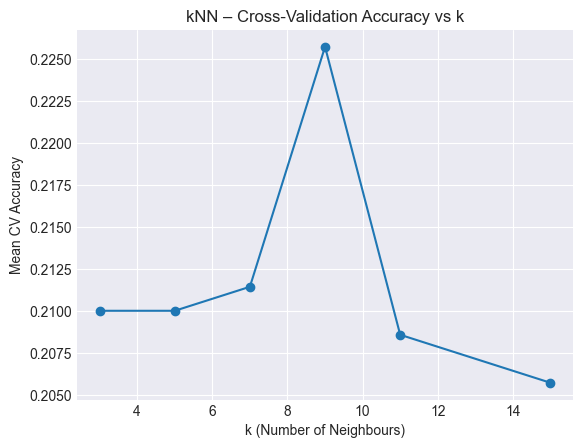

Best k = 9


In [30]:
from sklearn.model_selection import cross_val_score

k_values = [3, 5, 7, 9, 11, 15]
cv_scores = []

for k in k_values:
    model = Pipeline([
        ("scaler", StandardScaler()),
        ("model", KNeighborsClassifier(n_neighbors=k, weights="distance"))
    ])
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring="accuracy")
    cv_scores.append(scores.mean())

plt.plot(k_values, cv_scores, marker="o")
plt.title("kNN – Cross-Validation Accuracy vs k")
plt.xlabel("k (Number of Neighbours)")
plt.ylabel("Mean CV Accuracy")
plt.show()

best_k = k_values[np.argmax(cv_scores)]
print("Best k =", best_k)

In [31]:
best_knn = Pipeline([
    ("scaler", StandardScaler()),
    ("model", KNeighborsClassifier(n_neighbors=best_k, weights="distance"))
])
best_knn.fit(X_train, y_train)
y_pred_best = best_knn.predict(X_test)

print("Best kNN Accuracy:", accuracy_score(y_test, y_pred_best))
print(classification_report(y_test, y_pred_best))

Best kNN Accuracy: 0.22333333333333333
              precision    recall  f1-score   support

           1       0.11      0.11      0.11        54
           2       0.30      0.39      0.34        69
           3       0.20      0.21      0.21        52
           4       0.21      0.16      0.19        61
           5       0.25      0.20      0.22        64

    accuracy                           0.22       300
   macro avg       0.21      0.22      0.21       300
weighted avg       0.22      0.22      0.22       300



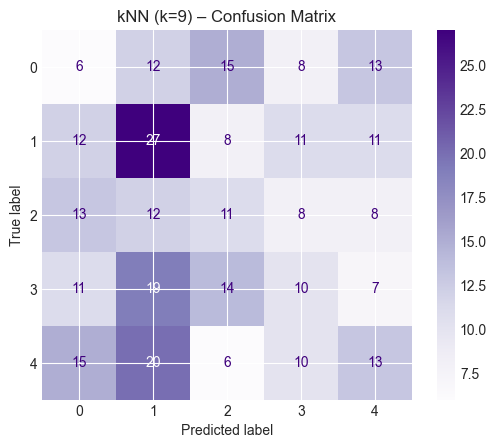

In [32]:
cm = confusion_matrix(y_test, y_pred_best)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Purples", values_format="d")
plt.title(f"kNN (k={best_k}) – Confusion Matrix")
plt.show()

In [35]:
import os
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Create results folders safely
os.makedirs("../results/metrics", exist_ok=True)
os.makedirs("../results/figures", exist_ok=True)

# --- Compute RMSE before saving ---
from sklearn.metrics import mean_squared_error
import numpy as np

rmse = np.sqrt(mean_squared_error(y_test, y_pred_best))
print(f"✅ RMSE: {rmse:.4f}")

# --- Save classification metrics ---
report_dict = classification_report(y_test, y_pred_best, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()

# Add RMSE as an extra row
report_df.loc["RMSE"] = {"precision": np.nan, "recall": np.nan, "f1-score": np.nan, "support": rmse}

# Save final version
metrics_path = "../results/metrics/knn_metrics.csv"
report_df.to_csv(metrics_path, index=True)
print(f"✅ Metrics (with RMSE) saved to: {metrics_path}")

# --- Save confusion matrix plot ---
cm = confusion_matrix(y_test, y_pred_best)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Purples", values_format="d")
plt.title(f"kNN (k={best_k}) – Confusion Matrix")

fig_path = "../results/figures/knn_confusion_matrix.png"
plt.savefig(fig_path, bbox_inches="tight")
plt.close()
print(f"✅ Confusion matrix saved to: {fig_path}")

✅ RMSE: 2.0567
✅ Metrics (with RMSE) saved to: ../results/metrics/knn_metrics.csv
✅ Confusion matrix saved to: ../results/figures/knn_confusion_matrix.png
